In [1]:
import kinetics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'
print(kinetics.__version__)

import itertools
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

1.4.3


Loading BokehJS ...

## Perfect enzyme modal
In this model I've set all the enzyme parameters to very good (but plausible) values.  The kcats are particually high.  

I've done this to try to get a feel for how the thermodynamics are limiting the reaction.  

In [2]:
aldolase = kinetics.Bi_Uni_sep_eq(kcat='aldolase_kcat',
                                  kma='aldolase_km_a', kmb='aldolase_km_b',
                                  kmp='aldolase_km_p',
                                  keq='aldolase_keq',
                                  a='a', b='b', p='p', enz='aldolase',
                                  substrates=['a', 'b'], products=['p'])

aldolase.parameters = {'aldolase_km_a': 100,
                       'aldolase_km_b': 100,
                       'aldolase_km_p': 100,
                       'aldolase_kcat': 1000}

aldolase.parameter_distributions = {'aldolase_keq': (2.97, 6.32)}

ring_close = kinetics.Uni_mass_action_eq(keq='ring_close_keq', kf='ring_close_kf',
                                         a='p', p='p_closed',
                                         substrates=['p'], products=['p_closed'])

ring_close.parameters = {'ring_close_kf': 1000000}

ring_close.parameter_distributions = {'ring_close_keq': (0.363, 1.15)}

In [3]:
# Set up the model
model = kinetics.Model()

# Add reactions
model.append(aldolase)
model.append(ring_close)

In [4]:
# calc conc (uM) of enzyme for 10 mg/ml
mgml = kinetics.mgml_to_uM({'aldolase': 27734}, 
                           {'aldolase': 10})
print(mgml)

{'aldolase': 360.57}


In [5]:
# Set time
model.set_time(0, 60*24, 500)

# Set starting concentrations with no error
# Issue setting concs to 0, so initialise at 1.
model.species = {"aldolase" : 360,
                 "a": 5000,
                 "b": 5000,
                 'p': 1,
                 'p_closed': 1}

# Command to prepare model for running.
model.setup_model()

In [6]:
# Run the model 1000 times, sampling from distributions
samples = kinetics.sample_uniforms(model, num_samples=200)
outputs = kinetics.run_all_models(model, samples)
df95 = kinetics.dataframes_quartiles(model, outputs, quartile=95)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 157.41it/s]


-- Substrate and Donor --


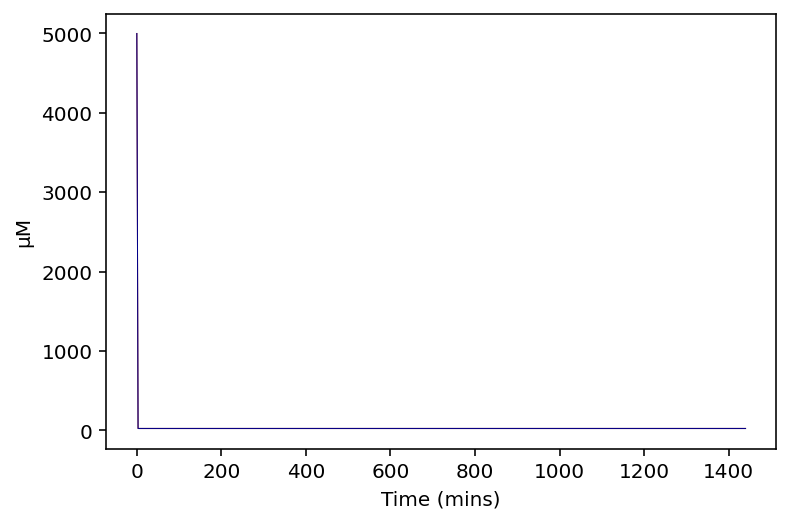

-- Product --


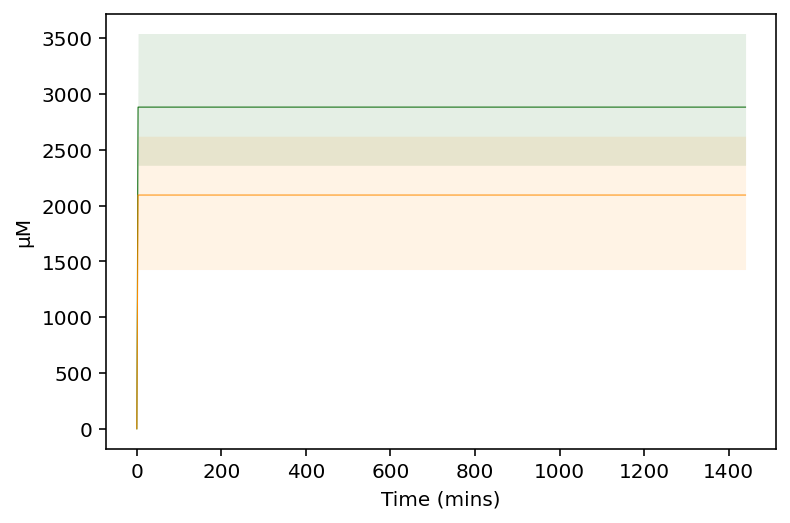

In [7]:
# Plot the confidence intervals
print("-- Substrate and Donor --")
kinetics.plot_ci_intervals(['a', 'b'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.show()


print("-- Product --")
kinetics.plot_ci_intervals(['p', 'p_closed'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.show()

## Plot donor excess vs conversion

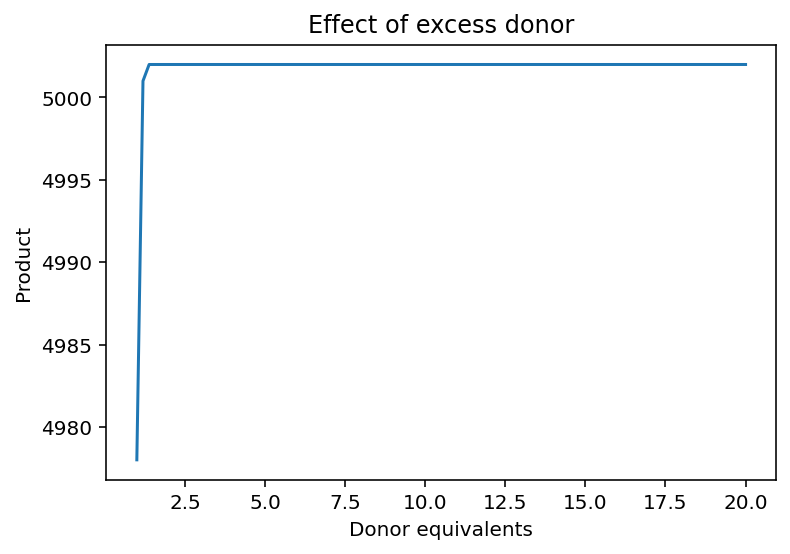

In [8]:
donor_range = np.linspace(1, 20, 100)
results = []
for conc in donor_range:
    model.species['b'] = conc*5000
    model.setup_model()
    model.run_model()
    df = model.results_dataframe()
    product = round(df['p'].iloc[-1],0) + round(df['p_closed'].iloc[-1],0)
    results.append(product)

plt.plot(donor_range, results, '-')
plt.xlabel("Donor equivalents")
plt.ylabel("Product")
plt.title("Effect of excess donor")
plt.show()

## Effect of pH and donor conc
Previous calculations have all used the equilibrium constant calculated at pH 7.5.  
What happens when we change pH (and also ionic strength and Mg conc). 

In [9]:
import numpy as np
from equilibrator_api import ComponentContribution, Q_
from equilibrator_assets.generate_compound import create_compound, get_or_create_compound
from rdkit import Chem
from equilibrator_api import Reaction
from equilibrator_cache import Q_
from component_contribution.predict import GibbsEnergyPredictor

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
%config InlineBackend.figure_format ='retina'

from math import log10, floor

from numpyarray_to_latex.jupyter import to_jup

cc = ComponentContribution()
GP = GibbsEnergyPredictor()

cc.p_h = Q_(7.5)
cc.p_mg = Q_(0)
cc.ionic_strength = Q_("0.25M")
T = 298.15
R = 8.31446261815324
cc.temperature = Q_(f"{T}K")

In [10]:
# define smiles
# define smiles
substrate_smi = "OC(COP(O)(O)=O)C=O"
donor_smi = "O=CCCCCCC"
open_product_smi = "O=CC(CCCCC)C(C(COP(O)(O)=O)O)O"  
closed_product_smi = "OC1C(CCCCC)C(O)OC1COP(O)(O)=O"  
list_smis = [substrate_smi, donor_smi, open_product_smi, closed_product_smi]

# get compounds for use with equilibrator
compounds = get_or_create_compound(cc.ccache, list_smis, mol_format="smiles")

substrate = compounds[0]
donor = compounds[1]
open_product = compounds[2]
closed_product = compounds[3]


*** Open Babel Warning  in InChI code
  #1 :Omitted undefined stereo
*** Open Babel Warning  in InChI code
  #1 :Omitted undefined stereo
*** Open Babel Warning  in InChI code
  #1 :Omitted undefined stereo
*** Open Babel Warning  in InChI code
  #1 :Omitted undefined stereo
*** Open Babel Warning  in InChI code
  #1 :Omitted undefined stereo
*** Open Babel Warning  in InChI code
  #1 :Omitted undefined stereo


In [11]:
aldolase = Reaction({substrate: -1, 
                     donor: -1,
                     open_product: +1})

ring_closing = Reaction({open_product: -1, 
                         closed_product: +1})

both_reactions = Reaction({substrate: -1, 
                           donor: -1,
                           closed_product: +1})

print(f'is balanced = {aldolase.is_balanced()}')
print(f'is balanced = {ring_closing.is_balanced()}')
print(f'is balanced = {both_reactions.is_balanced()}')

is balanced = True
is balanced = True
is balanced = True


In [12]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def calc_keq(reaction, pH=7.5):
    ''' returns the Keq for a given reaction, with error '''
    
    cc.p_h = Q_(pH)
    dG0_prime = cc.standard_dg_prime(reaction)
    dG0_prime_j_mol = dG0_prime.value.m_as("J/mol")
    dG0_prime_j_mol_error = dG0_prime.error.m_as("J/mol")
    
    dG0_prime_lower = dG0_prime_j_mol - dG0_prime_j_mol_error
    dG0_prime_upper = dG0_prime_j_mol + dG0_prime_j_mol_error
    lower_upper = sorted([dG0_prime_lower, dG0_prime_upper], reverse=True)
    
    keq = round_sig(np.exp(-dG0_prime_j_mol/(R*T)))
    keq_lower = round_sig(np.exp(-lower_upper[0]/(R*T)))
    keq_upper = round_sig(np.exp(-lower_upper[1]/(R*T)))

    #keq_error = np.exp(-dG0_prime_j_mol_error/(R*T))
    #print([keq_lower, keq_upper])
    return keq, [keq_lower, keq_upper]

In [13]:
model.species = {"aldolase" : 360,
                 "a": 5000,
                 "b": 5000,
                 'p': 1,
                 'p_closed': 1}

# Command to prepare model for running.
model.setup_model()

## pH vs vs amine vs conversion

In [14]:
from bokeh.palettes import Viridis6 as palette
colors = itertools.cycle(palette) 

pH_range = np.linspace(4, 12, 25)
amine_range = [10, 5, 2, 1.1, 1]

results = []
p = figure(title="pH & donor vs conversion", x_axis_label='pH', y_axis_label='Product')


for amine in amine_range:
    results = []
    model.species['b'] = amine*5000
    model.setup_model()
    
    for pH in pH_range:
        model.parameters['aldolase_keq'] = calc_keq(aldolase, pH=pH)[0]
        model.parameters['ring_close_keq'] = calc_keq(ring_closing, pH=pH)[0]
        model.setup_model()
        model.run_model()
        df = model.results_dataframe()
        product = round(df['p'].iloc[-1],0) + round(df['p_closed'].iloc[-1],0)
        results.append(product)
        
    p.line(pH_range, results, legend_label=f"{amine} donor equivs", color=next(colors), line_width=2)

show(p)


In [15]:
pH_range = np.linspace(11, 5, 7)
amine_range = [1, 1.1, 10, 20]
p = figure(title="pH & donor vs conversion", x_axis_label='Donor equivs', y_axis_label='Product')

from bokeh.palettes import Viridis7 as palette
colors = itertools.cycle(palette) 


for pH in pH_range:
    results = []
    for amine in amine_range:
        model.species['nh2'] = amine*10000
        model.parameters['aldolase_keq'] = calc_keq(aldolase, pH=pH)[0]
        model.parameters['ring_close_keq'] = calc_keq(ring_closing, pH=pH)[0]
        model.setup_model()
        model.run_model()
        df = model.results_dataframe()
        product = round(df['p'].iloc[-1],0) + round(df['p_closed'].iloc[-1],0)
        results.append(product)
        
    p.line(amine_range, results, legend_label=f"pH {pH}", color=next(colors), line_width=2)

show(p)